In [1]:
import glob
import logging
import os
import time
import urllib.parse
from datetime import datetime, date, timedelta

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
import tensorflow as tf
from astral import LocationInfo
from astral.sun import sun
from keras import layers, models
from prophet import Prophet
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

import strat_defs # custom functions
import prep_data

In [2]:
def gen_powerset(some_list):
    powerset = [[]]

    for i in some_list:
        powerset += [x+[i] for x in powerset]

    return powerset

In [3]:
# Suppress prophet logging (prophet prints something each time)
for lib in ["prophet", "cmdstanpy"]:
    logger = logging.getLogger(lib)
    logger.setLevel(logging.ERROR)  # Set logging level
    
    # Remove all existing handlers
    while logger.hasHandlers():
        logger.removeHandler(logger.handlers[0])
    
    # Add a NullHandler to prevent logs from propagating
    logger.addHandler(logging.NullHandler())

### Build dataframe for testing

In [5]:
# Configuration
moving_average_config = prep_data.MovingAverageConfig(short_window=10, long_window=50)
bollinger_config = prep_data.BollingerConfig(window=90, num_std=3.0)
macd_config = prep_data.MACDConfig(short_window=12, long_window=26)

indicator_config = prep_data.IndicatorConfig(
    ticker='SPY',
    target='Adj Close', # probably should always be Adj Close
    rsi_window = 30,
    moving_average=moving_average_config,
    bollinger=bollinger_config,
    macd=macd_config
)

In [6]:
stocks_df, wiki_pageviews, ffr_raw, weather, gt_adjusted = prep_data.load_data()

prepd_data = prep_data.prep_data(
    stocks_df,
    wiki_pageviews,
    ffr_raw,
    weather,
    gt_adjusted,
    config=indicator_config,drop_tickers=True
)

### Set configuration and parameters for model testing

In [8]:
# Configuration
keras_config = strat_defs.KerasConfig(proba=0.5, sequence_length=30, epochs=20)
proba_config = strat_defs.ProbaConfig(knn = 0.5, logit = 0.5, mlp = 0.5, rf = 0.5, svc = 0.5, xgboost = 0.5)

backtest_config = strat_defs.BacktestConfig(
    overbought = 70,
    retrain_every = 10,
    logit_warm_start = False, # true with drop tickers = false fails. not sure why. true with drop tickers = True fails. not sure why.    
    proba = proba_config,
    keras = keras_config
)

**s_date**\
data start date S&P 500 minimum is 1993-01-29, Wikipedia page views minimum is 2015-07-01

**exclude_vars**\
enum {"Open","High","Low","Close","Adj Close","Volume","movement", "views"}

**strategy_list**\
enum {"Hold","SMA","RSI","VWAP","Bollinger","Breakout","Prophet","KNN","LinearSVC","Logit","MLP","RandomForest","SVC","SVC_proba","XGBoost","Keras","Perfection"

From fast to slow (usually - times with drop_tickers=True):\
Hold, Perfection, SMA, RSI, VWAP, Bollinger, Breakout, KNN(*4s*), LinearSVC(*5s*), Logit(*20s*), XGBoost(*24s*), SVC(*102s*), Prophet(*160s*), SVC_proba(*200s*), MLP(*2978s*), Keras(*4048s*)

\
*If testing Breakout, "High" and "Low" cannot be excluded*

In [10]:
s_date = "2015-07-01"
exclude_vars = ("Open","High","Low","Close","Volume")

# initial_train_period = 1890 # 2015-07-01 start predicting in 2023
initial_train_period = 2140 # 2015-07-01 start predicting in 2024
# initial_train_period = 7535 # 1993-01-29 start predicting in 2024
random_state = 42
n_jobs = None
                                                     
# Strategies to test
strategy_list = ["Hold", "KNN", "LinearSVC", "Logit", "XGBoost", "SVC"]

### Run models

In [12]:
%%time
df_for_chart = prepd_data.loc[prepd_data['Date']>=s_date].reset_index(drop=True)
df_for_chart = df_for_chart.drop(columns=[
    col for col in df_for_chart.columns 
    if any(col.startswith(prefix) for prefix in exclude_vars) and col != indicator_config.target+"_"+indicator_config.ticker
])
df_for_chart = df_for_chart.dropna(axis='columns') # drop columns with an na

print(f'Training on data set with {len(df_for_chart)} rows and {df_for_chart.shape[1]-1} features')

# Calculate portfolio value over time
strat_bds, strat_mods = {}, {}
for strat in strategy_list:
    start_time = time.time()
    print(f'\n{strat}', end=" ")
    backtested_data,model,score = strat_defs.backtest_strategy(
        data=df_for_chart,
        strategy=strat,
        target=indicator_config.target,
        ticker=indicator_config.ticker,
        config=backtest_config,
        initial_train_period=initial_train_period,
        random_state=random_state,
        n_jobs=n_jobs
    )
    end_time = time.time()
    print(f'score = {score}, time = {end_time-start_time}')
    
    strat_bds[strat] = backtested_data
    strat_mods[strat] = model

Training on data set with 2499 rows and 32 features

Hold score = None, time = 0.0022978782653808594

KNN score = 0.6963855421686747, time = 1.680988073348999

LinearSVC score = 0.5534136546184739, time = 3.852461814880371

Logit score = 0.5538152610441767, time = 20.422686100006104

XGBoost score = 1.0, time = 24.871264696121216

SVC score = 0.5522088353413654, time = 102.6413631439209
CPU times: user 12min 26s, sys: 2min 42s, total: 15min 8s
Wall time: 2min 33s


In [13]:
proba_strats = [x for x in strategy_list if x not in ["Hold","LinearSVC","SVC","Prophet"]]

combos = [x for x in gen_powerset(proba_strats) if len(x) > 1]

mod_mod_dic = {}
for mods in combos:
    # Model of models
    if indicator_config.ticker == "SPY":
        df_prev = strat_bds[mods[0]][['Date','Daily_Return','Target','proba_1','Signal']]
    else:
        df_prev = strat_bds[mods[0]][['Date','Daily_Return_SPY','Daily_Return','Target','proba_1','Signal']]

    df_prev = df_prev.rename(columns={'proba_1': 'proba_1'+mods[0], 'Signal': 'Signal_'+mods[0]})

    for i in mods[1:]:
        mod_mod = strat_bds[i][['Date','proba_1','Signal']].rename(columns={'proba_1': 'proba_1'+i, 'Signal': 'Signal_'+i})
        mod_mod = mod_mod.merge(df_prev,on='Date')
        df_prev = mod_mod

    # All strats predict 0
    signal_columns = mod_mod.columns[mod_mod.columns.str.contains('Signal')]

    mod_mod['Signal_all0'] = np.where(mod_mod[signal_columns].eq(0).all(axis=1), 0, 1) 

    mod_mod['Strategy_Return_all0'] = mod_mod['Signal_all0'].shift(1) * mod_mod['Daily_Return']

    # Using strategy with most confident prediction (furthest from 50%)
    proba_cols = [col for col in mod_mod.columns if col.startswith('proba_1')]

    for i in proba_cols:
        mod_mod["dist_"+i] = abs(mod_mod[i] - 0.5)

    dist_cols = [col for col in mod_mod.columns if col.startswith('dist_')]

    mask = mod_mod[proba_cols].notna().any(axis=1)
    mod_mod.loc[mask, 'proba_1max_col'] = mod_mod.loc[mask, proba_cols].idxmax(axis=1, skipna=True)
    mod_mod['proba_1max_col'] = mod_mod['proba_1max_col'].str.replace("dist_","")
    
    mod_mod['yesterday_proba_1max_col'] = mod_mod['proba_1max_col'].shift(1)
    
    mod_mod['yesterday_proba_1max'] = mod_mod.apply(
        lambda row: row[row['yesterday_proba_1max_col']] if pd.notnull(row['yesterday_proba_1max_col']) else 1, axis=1
    )

    mod_mod['Signal'] = mod_mod['yesterday_proba_1max'].round()

    mod_mod['Strategy_Return'] = mod_mod['Signal'].shift(1) * mod_mod['Daily_Return']

    if indicator_config.ticker != "SPY":
        mod_mod.loc[:initial_train_period, 'Strategy_Return'] = mod_mod['Daily_Return_SPY']

    mod_mod.loc[0, 'Strategy_Return'] = np.nan

    mod_mod_dic["_".join(mods)] = mod_mod

### Results

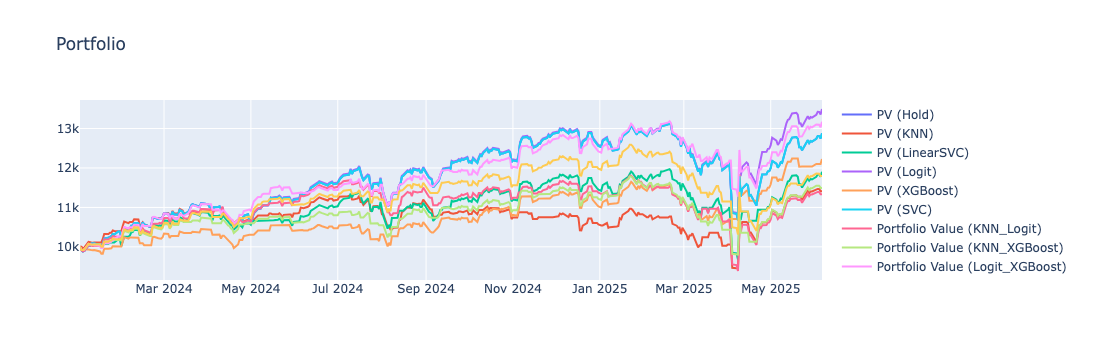

In [41]:
initial_capital = 10000 # scalar

# Plot Daily Portfolio Value
fig = go.Figure()

if indicator_config.ticker != "SPY":
    df = strat_bds['Hold'][initial_train_period:].copy()
    df.loc[initial_train_period, 'Strategy_Return'] = 0
    df['Portfolio_Value'] = (1 + df['Daily_Return_SPY']).cumprod() * initial_capital

    fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value'], mode='lines', name='PV SPY_Hold'))

for strat in strategy_list:
    df = strat_bds[strat][initial_train_period:].copy()
    df.loc[initial_train_period, 'Strategy_Return'] = 0
    df['Portfolio_Value'] = (1 + df['Strategy_Return']).cumprod() * initial_capital

    fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value'], mode='lines', name=f'PV ({strat})'))

try:
    for mods in combos:
        df = mod_mod_dic["_".join(mods)][initial_train_period:].copy()
        df.loc[initial_train_period, 'Strategy_Return'] = 0
        df['Portfolio_Value'] = (1 + df['Strategy_Return']).cumprod() * initial_capital

        fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value'], mode='lines', name=f"Portfolio Value ({'_'.join(mods)})"))
except:
    pass

fig.update_layout(title="Portfolio")
fig.show()

In [16]:
# % right
dat = []
for i in strategy_list:
    after_train = strat_bds[i][initial_train_period:]
    cc = after_train.dropna().reset_index(drop=True)
    cc['win'] = cc['Target']==cc['Signal']

    win = cc['win'].value_counts(normalize=True)[True]
    dat.append(f'{win:.2%}')

try:
    combos_join = ["_".join(x) for x in combos]
    for i in combos_join:
        cc = mod_mod_dic[i].dropna().reset_index(drop=True)
        cc['win'] = cc['Target']==cc['Signal']

        win = cc['win'].value_counts(normalize=True)[True]
        dat.append(f'{win:.2%}')

    review = pd.DataFrame({'strategy': strategy_list+combos_join, 'pct_right': dat})
except:
    review = pd.DataFrame({'strategy': strategy_list, 'pct_right': dat})

review.sort_values(by='pct_right', ascending=False)

,strategy,pct_right
3,Logit,59.05%
0,Hold,58.50%
5,SVC,58.50%
8,Logit_XGBoost,56.42%
6,KNN_Logit,53.63%
2,LinearSVC,53.48%
9,KNN_Logit_XGBoost,51.96%
1,KNN,50.14%
4,XGBoost,50.14%
7,KNN_XGBoost,49.16%


In [17]:
# Will this ticker go up tomorrow?
for i in strategy_list:
    if 'proba_1' in strat_bds[i].columns:
        print(f'{i}: {strat_bds[i]['Signal'].iloc[-1]} (prob_1: {strat_bds[i]['proba_1'].iloc[-1]})')
    else:
        print(f'{i}: {strat_bds[i]['Signal'].iloc[-1]}')

Hold: 1
KNN: 1 (prob_1: 1.0)
LinearSVC: 1.0
Logit: 1 (prob_1: 0.5585606151230417)
XGBoost: 1 (prob_1: 0.9108421206474304)
SVC: 1.0


In [18]:
# In the case where signal is 0 across everything, how often does the market actually go down?
KNN_Logit_XGBoost = mod_mod_dic['KNN_Logit_XGBoost']
KNN_Logit_XGBoost_all0= KNN_Logit_XGBoost.loc[KNN_Logit_XGBoost['Signal_all0']==0]
KNN_Logit_XGBoost_all1= KNN_Logit_XGBoost.loc[KNN_Logit_XGBoost['Signal_all0']==1]
print(f'There are {len(KNN_Logit_XGBoost_all0)} case(s) where signal is 0 across everything.')
print(f'There are {len(KNN_Logit_XGBoost_all1)} case(s) where signal is 1 across everything.')
print(f'Of these, there are {sum(KNN_Logit_XGBoost_all1['Target'])} case(s) where Target is 1.')
print(sum(KNN_Logit_XGBoost_all1['Target'])/len(KNN_Logit_XGBoost_all1))

There are 0 case(s) where signal is 0 across everything.
There are 2499 case(s) where signal is 1 across everything.
Of these, there are 1380 case(s) where Target is 1.
0.5522208883553421


### Testing

In [20]:
########################################################################################################
# Testing ##############################################################################################
########################################################################################################

In [21]:
px.histogram(strat_bds['Logit']['proba_1'].dropna(),nbins=50)

In [22]:
px.histogram(strat_bds['KNN']['proba_1'].dropna(),nbins=50)

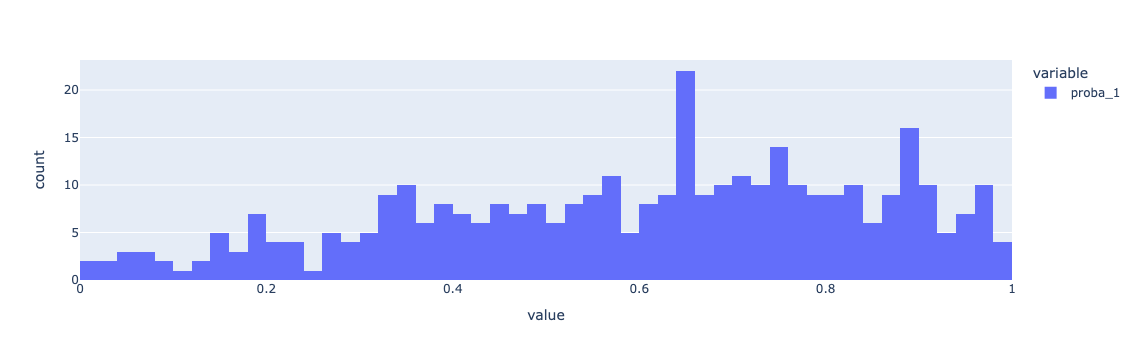

In [23]:
px.histogram(strat_bds['XGBoost']['proba_1'].dropna(),nbins=50)